<a href="https://colab.research.google.com/github/Wisnuardhi/Project-1/blob/main/PRAK4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Date          421570 non-null  object 
 2   Temperature   421570 non-null  float64
 3   Fuel_Price    421570 non-null  float64
 4   MarkDown1     421570 non-null  float64
 5   MarkDown2     421570 non-null  float64
 6   MarkDown3     421570 non-null  float64
 7   MarkDown4     421570 non-null  float64
 8   MarkDown5     421570 non-null  float64
 9   CPI           421570 non-null  float64
 10  Unemployment  421570 non-null  float64
 11  IsHoliday     421570 non-null  bool   
 12  Type          421570 non-null  object 
 13  Size          421570 non-null  int64  
 14  Dept          421570 non-null  int64  
 15  Weekly_Sales  421570 non-null  float64
dtypes: bool(1), float64(10), int64(3), object(2)
memory usage: 48.6+ MB
            Store  Tempe

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


,Score
Squared Error,
MSE,2508793.97
MAE,1189.13
RMSE,1583.92
STD DVTN,1047


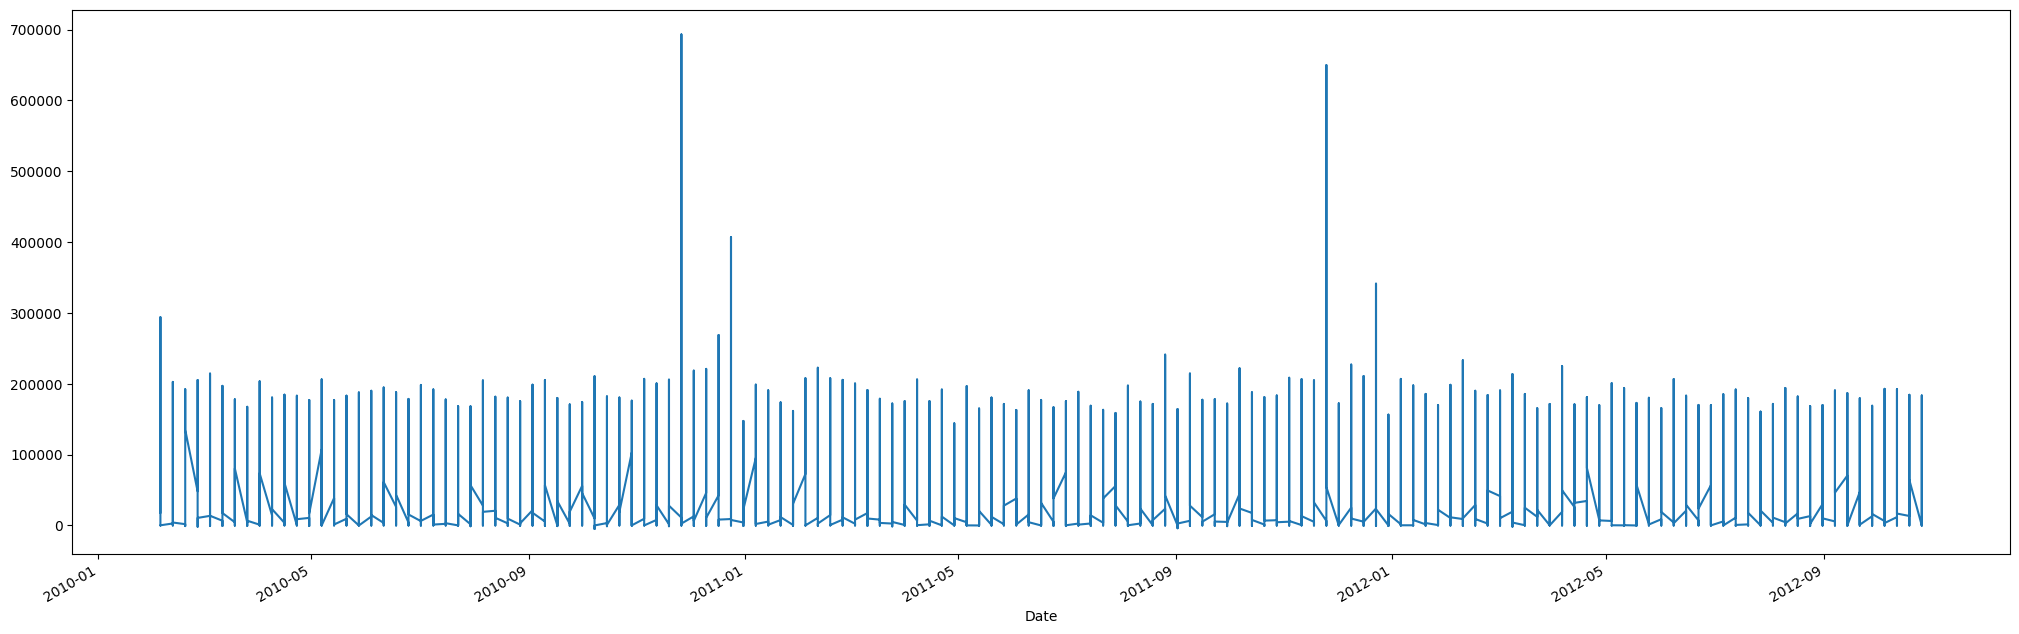

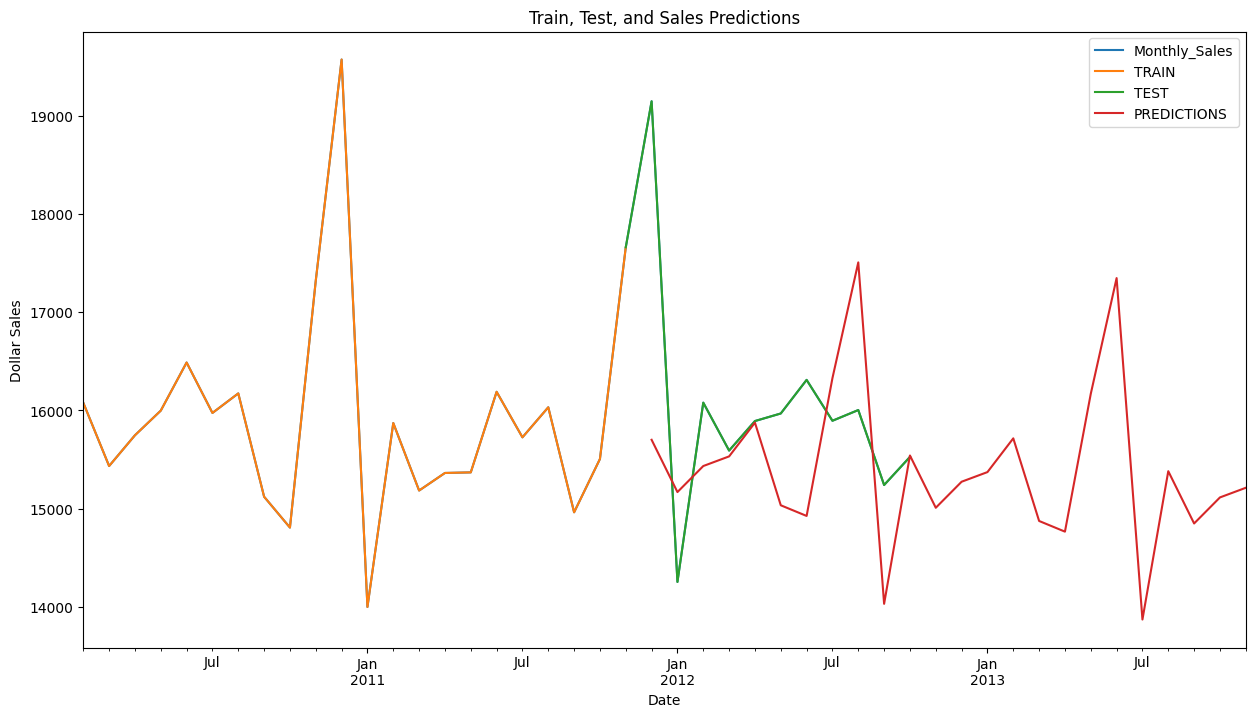

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# import the 3 datasets and assign them to their own variable https://drive.google.com/drive/folders/1duXATfPR5cr42pnLNRp_UlbZ4kTb7xHW?usp=sharing
features = pd.read_csv('/content/drive/MyDrive/machine learning/Features data set.csv')
sales = pd.read_csv('/content/drive/MyDrive/machine learning/sales data-set.csv')
stores = pd.read_csv('/content/drive/MyDrive/machine learning/stores data-set.csv')


# ## Merge the Datasets
# merge the 3 separate datasets using the merge function.
features = features.merge(stores, on = 'Store')
df = features.merge(sales, on = ['Store','Date','IsHoliday'])
df=df.fillna(0)
df.shape
df.info()
df.head()
df.describe()

# Verifikasi bahwa semua nilai yang hilang telah diganti dengan 0
missing_values_before = df.isnull().sum().sum()
missing_values_after = df.isnull().sum().sum()

# ## Creating an Index Based on the DATES # sort the dataframe by date
df = df.sort_values(by='Date')

# parse the 'Day', 'Month', and 'Year' from the 'Date' column # change the 'Date' column to the datetime format df['Date'] = pd.to_datetime(df['Date'])
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')
# make new columns from the day, month, and year
df['Day'] = df['Date'].dt.day
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year
# We just want the sales data to predict. Let's plot the 'Weekly Sales' column
# Currently, Sales data is shown on a weekly basis. 4 weeks a month and 52 weeks a year.
# set the index to the date column, make sure its in the datetime format
df = df.set_index('Date')
print(df)

# plot the Weekly Sales column
df['Weekly_Sales'].plot(figsize=(25,8)); # ## Extract the Sales Data

# The Weekly Sales column will be pulled out to create a new dataframe
df_Sales = df[['Weekly_Sales']] # check the new dataframe
df_Sales.head()

# Next, we resample the dataframe to show average sales per month only, instead of every week.
df_Sales = df_Sales.resample(rule='M').mean()
df_Sales.head()
# rename the 'Weekly_Sales' column to 'Monthly_Sales'
df_Sales = df_Sales.rename(columns={'Weekly_Sales':'Monthly_Sales'}) # plot the sales on a lineplot
df_Sales.plot(figsize=(20,8))
plt.title('Average Monthly Sales')
plt.xlabel('Date')
plt.ylabel('Dollar Sales');
# check for nan values in the df
df_Sales.isnull().sum()



# export the dataframe so we can use it again
df.to_csv('Retail Sales Monthly.csv',index=False)

# ## Split the Data into Training and Test Splits
# lets find out how big the dataframe is. We need to figure out the size. We are going to split the data frame into training and test splits.
df_Sales.shape

# The size of the test set is typically about 20% of the total sample. But here, you'll see that I choose 40%. Why? Because I want to predict one yea #
# In other words, does my test data match in length as far as I'm willing to forecast out?
# muliply 36 by 0.4 to find how many months to subtract to create the training data
36 * 0.4

# subtract 14 from 36 to get 22 months
36 - 14

# Create the Train and Test variables
# sales train variable from the begining of the dataframe to 22 months
sales_train = df_Sales.iloc[:22]

# sales test variable from 22 months to the end of the dataframe
sales_test = df_Sales.iloc[21:]

#print the test variable
sales_test

# ## Exponential Smoothing
# import Expontential Smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# I'll use the additive method because the seasonal variations are roughly constant through the series # Here, we fit the model on the training data 'sales_train'
fitted_model = ExponentialSmoothing(sales_train['Monthly_Sales'], trend = 'add', seasonal = 'add', seasonal_periods = 10).fit()

# Assign the 2 years of forecasting to the test predictions variable
# Our predictions are grabbing the fitted model, then off the fitted model object, forecast 24 months into the future
test_predictions = fitted_model.forecast(24)

# print the test_predictions
# this is a series that predicts certain values for a date test_predictions
# ## Plot the Predictions against the Training, and Test Sets
# plot the test predictions against the past sales and test set
sales_train['Monthly_Sales'].plot(legend=True, label= 'TRAIN', figsize=(15,8))
sales_test['Monthly_Sales'].plot(legend=True, label= 'TEST', figsize=(15,8))
test_predictions.plot(legend=True, label= 'PREDICTIONS', figsize=(15,8))
plt.title('Train, Test, and Sales Predictions')
plt.xlabel("Date")
plt.ylabel("Dollar Sales");
# ## Check the Accuracy of the Model # check the accuracy of the model
from sklearn.metrics import mean_squared_error, mean_absolute_error

# find the sales standard deviation and mean
sales_test.describe()
# change the size of the forecast
# we have to make the size of the forecast the same as the test set in order to get the squared errors test_predictions = fitted_model.forecast(15)
# Assume sales_test is defined to have 12 months of data
test_predictions = fitted_model.forecast(steps=len(sales_test))

# find the mean squared error
MSE = mean_squared_error(sales_test, test_predictions)

# find the mean absolute error
MAE = mean_absolute_error(sales_test, test_predictions)
# find the root mean squared error
RMSE = np.sqrt(mean_squared_error(sales_test, test_predictions))

# suppress scientific notation in the dataframe
pd.options.display.float_format = '{:.2f}'.format

# create a dataframe showing the error results
results = pd.DataFrame({'Squared Error': ['MSE','MAE','RMSE','STD DVTN'], 'Score': [MSE,MAE,RMSE, '1047']})
results = results.set_index('Squared Error')
results
# ## Conclusion
# The root mean squared error for our model accuracy is 1270. When we compare it the standard deviation of the original data of 1047, we see that it